In [1]:
import heapq
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def update_plot(frame, grid, paths):
    plt.cla()
    plt.imshow(grid, cmap='binary')

    for i, path in enumerate(paths):
        if frame < len(path):
            x, y = path[frame]
            plt.text(y, x, str(i+1), ha='center',
                     va='center', fontsize=10, color='red')

    # plt.gca().invert_yaxis()
    plt.xticks(range(len(grid[0])))
    plt.yticks(range(len(grid)))


In [8]:
import heapq
from collections import defaultdict, deque

def low_level_search(start, goal, grid, constraints, agent_id, max_time=100):
    """A* search for a single agent that respects constraints."""
    def heuristic(pos):
        return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])

    def get_neighbors(pos):
        x, y = pos
        neighbors = [(x, y)]
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < len(grid) and 0 <= ny < len(grid[0]) and grid[nx][ny] == 0:
                neighbors.append((nx, ny))
        return neighbors

    open_set = []
    heapq.heappush(open_set, (heuristic(start), 0, start, []))
    visited = set()

    while open_set:
        _, g, current, path = heapq.heappop(open_set)
        if (current, len(path)) in visited:
            continue
        visited.add((current, len(path)))

        # Goal check
        if current == goal:
            return path + [current]

        # Expand neighbors
        for neighbor in get_neighbors(current):
            conflict = False

            for c in constraints:
                if c['agent'] != agent_id:
                    if c['type'] == 'vertex':
                        # Check for vertex conflict
                        if c['pos'] == neighbor and c['time'] == g + 1:
                            conflict = True
                            break
                    elif c['type'] == 'edge':
                        # Check for edge conflict
                        
                        if current != neighbor:
                            if c['edge'] == (neighbor, current) and c['time'] == g + 1:
                                conflict = True
                                break
                        # # Also check reverse edge for wait actions being misinterpreted as conflicts
                        # if c['edge'] == (neighbor, current) and c['time'] == g + 1:
                        #     conflict = True
                            # break

            if not conflict:
                heapq.heappush(open_set, (g + heuristic(neighbor), g + 1, neighbor, path + [current]))

    return None  # No path found


def prioritized_planning(grid, starts, goals, priorities):
    constraints = []
    paths = [[] for _ in range(len(starts))]

    for agent in priorities:
        path = low_level_search(starts[agent], goals[agent], grid, constraints, agent)
        if path is None:
            return "No Solution"
        paths[agent] = path

        if path is None:
            return False  # No solution found for the current agent
    
        for time, pos in enumerate(paths[agent]):
            # Add a vertex constraint
            constraints.append({'type': 'vertex', 'agent': agent, 'pos': pos, 'time': time})
            # Add an edge constraint (to prevent moving into `a`'s next position)
            if time < len(paths[agent]) - 1:
                edge = (paths[agent][time], paths[agent][time + 1])
                constraints.append({'type': 'edge', 'agent': agent, 'edge': edge, 'time': time + 1})

    return paths

# Example Usage
if __name__ == "__main__":
    grid = [
        [0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0],
    ]

    starts = [(4, 0), (4, 1)]
    goals = [(0, 4), (4, 0)]

    paths = prioritized_planning(grid, starts, goals, [0, 1])

    if paths:
        for i, path in enumerate(paths):
            print(f"Agent {i}: {path}")
    else:
        print("No solution found")


Agent 0: [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (3, 4), (2, 4), (1, 4), (0, 4)]
Agent 1: [(4, 1), (3, 1), (4, 1), (4, 0)]


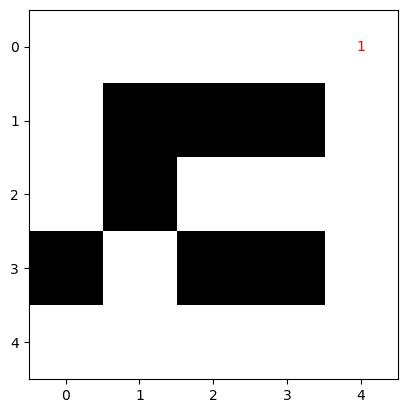

In [4]:
fig = plt.figure()
ani = FuncAnimation(fig, update_plot, frames=max(len(path)
                    for path in paths), fargs=(grid, paths), interval=500)
ani.save('paths.gif', writer='imagemagick')
plt.show()